In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("MarketBasketPyspark") \
    .getOrCreate()

23/11/02 18:38:51 WARN Utils: Your hostname, gabs-Aspire-A514-54 resolves to a loopback address: 127.0.1.1; using 192.168.15.33 instead (on interface wlp0s20f3)
23/11/02 18:38:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 18:38:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
from pyspark.sql import functions as f

In [4]:
df = spark.read.csv("data/basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df.show(5)

+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  1|
|       soda|pickled vegetables|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  2|
|canned beer|   misc. beverages|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  3|
|    sausage|  hygiene articles|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows



In [5]:
df_all = spark.read.csv('data/Groceries_dataset.csv', header=True).withColumn('id', f.monotonically_increasing_id())
df_all.show(5)

+-------------+----------+----------------+---+
|Member_number|      Date| itemDescription| id|
+-------------+----------+----------------+---+
|         1808|21-07-2015|  tropical fruit|  0|
|         2552|05-01-2015|      whole milk|  1|
|         2300|19-09-2015|       pip fruit|  2|
|         1187|12-12-2015|other vegetables|  3|
|         3037|01-02-2015|      whole milk|  4|
+-------------+----------+----------------+---+
only showing top 5 rows



In [8]:
# Count how many purchases per customer
num_purchases = df_all.groupBy('Member_number').count()
num_purchases.show(5)

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



In [9]:
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist

(array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

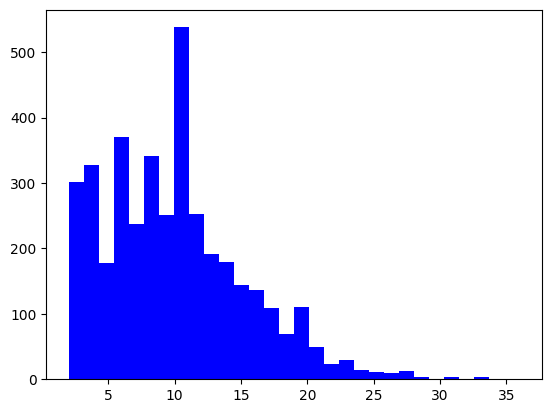

In [10]:
# Plotting the distribution of number of purchases
fig, ax = plt.subplots()
hist(ax, num_purchases.select('count'), bins=30, color=['blue'])

In [13]:
df_basket = df.select('id', f.array([df[c] for c in df.columns[:11]]).alias('basket'))
df_basket.show(5, truncate=False)

+---+--------------------------------------------------------------------------------------------+
|id |basket                                                                                      |
+---+--------------------------------------------------------------------------------------------+
|0  |[whole milk, pastry, salty snack, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]           |
|1  |[sausage, whole milk, semi-finished bread, yogurt, NULL, NULL, NULL, NULL, NULL, NULL, NULL]|
|2  |[soda, pickled vegetables, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]            |
|3  |[canned beer, misc. beverages, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]        |
|4  |[sausage, hygiene articles, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]           |
+---+--------------------------------------------------------------------------------------------+
only showing top 5 rows



In [14]:
# Remove nulls
df_basket = df_basket.select('id', f.array_except('basket', f.array(f.lit(None))).alias('basket'))
df_basket.show(5, truncate=False)

+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
|3  |[canned beer, misc. beverages]                    |
|4  |[sausage, hygiene articles]                       |
+---+--------------------------------------------------+
only showing top 5 rows



In [15]:
from pyspark.ml.fpm import FPGrowth

In [16]:
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')
model = fp.fit(df_basket)
model.freqItemsets.show(10, truncate=False)

+------------------------+----+
|items                   |freq|
+------------------------+----+
|[cocoa drinks]          |16  |
|[canned fruit]          |21  |
|[specialty cheese]      |72  |
|[chocolate marshmallow] |60  |
|[pet care]              |85  |
|[house keeping products]|45  |
|[jam]                   |34  |
|[light bulbs]           |29  |
|[beef]                  |508 |
|[beef, frankfurter]     |15  |
+------------------------+----+
only showing top 10 rows



In [17]:
# When we compare the row from this table where the
# antecedent is `[sausage, whole milk]` and the consequent
# is [yogurt] to the same row from the first notebook that
# uses the Apriori algorithm, we find the exact same values
# for confidence, lift and support.
# It seems that the algorithms converge for this dataset!
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, truncate=False)

+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[bottled beer]       |[whole milk]|0.15781710914454278|0.9993302598941151|0.007150972398583172 |
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[ham]                |[whole milk]|0.16015625         |1.0141421789039358|0.0027400922274944863|
|[frozen fish]        |[whole milk]|0.1568627450980392 |0.9932870312746344|0.0010693042839002875|
|[sausage, whole mil

In [19]:
from pyspark.sql import Row

In [27]:
columns = ['basket']
row1 = Row(['ham', 'yogurt', 'light bulbs'])
row2 = Row(['jam', 'cocoa drinks', 'pet care'])
data = [row1, row2]
new_df = spark.createDataFrame(data, schema=columns)
new_df.show(truncate=False)

+-----------------------------+
|basket                       |
+-----------------------------+
|[ham, yogurt, light bulbs]   |
|[jam, cocoa drinks, pet care]|
+-----------------------------+



In [28]:
model.transform(new_df).show(5, truncate=False)

+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|basket                       |prediction                                                                                                                                                                                                                                                                                                             